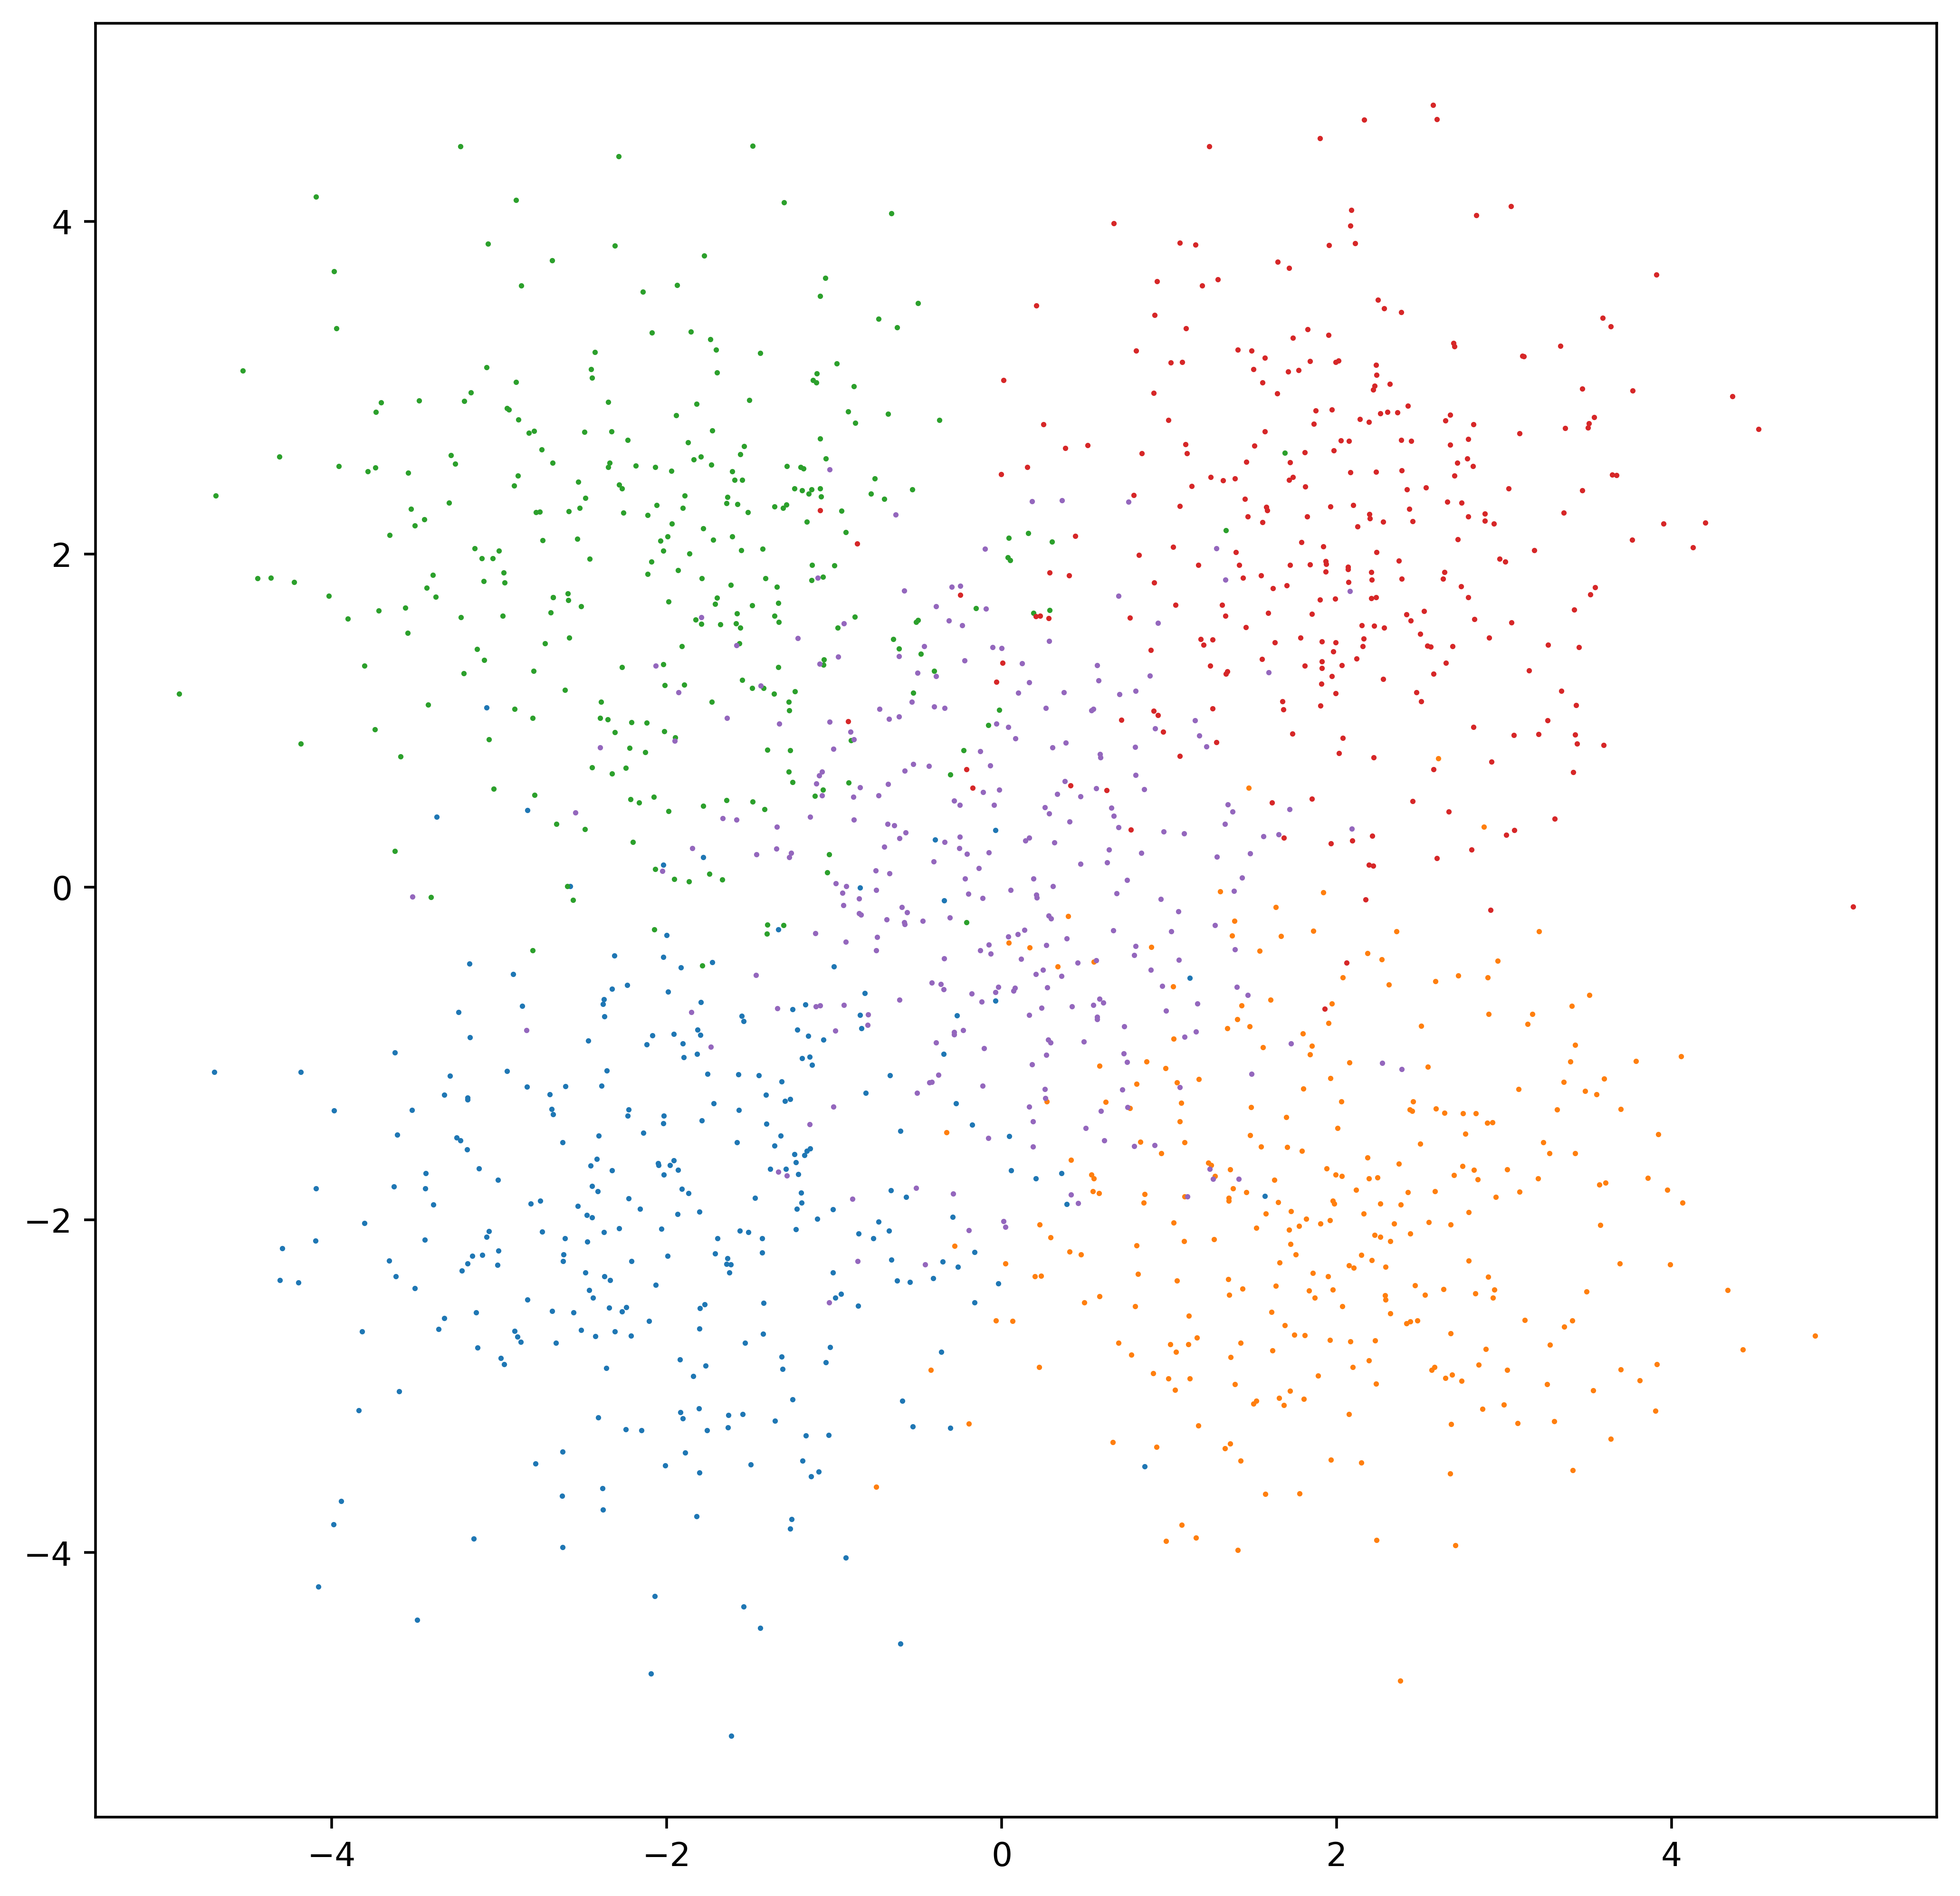

GPUs are used!
FVMF RELOADED
GPUs are used!
FVMF RELOADED
0
Random Init Utilized


/opt/uio/modules/rhel8/easybuild/software/Miniconda3/lmsunde/envs/BNN2/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


1
loss: tensor(173.3571, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(141.5353, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.6059, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(1.3085, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(124.3686, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(96.8984, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.7735, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(2.1217, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(93.7074, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(68.8642, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.9905, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(2.5730, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(83.0950, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(58.9930, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.9786, d

Component 0 Accuracy: 1017.0/1200
Component 1 Accuracy: 1009.0/1200
Component 2 Accuracy: 1017.0/1200
Component 3 Accuracy: 1028.0/1200
Component 4 Accuracy: 1002.0/1200
Component 5 Accuracy: 1014.0/1200
Component 6 Accuracy: 1005.0/1200
Component 7 Accuracy: 1028.0/1200
Component 8 Accuracy: 1011.0/1200
Component 9 Accuracy: 1007.0/1200
Posterior Mean Accuracy: 1026.0/1200
Ensemble Accuracy: 1025/1200
0
Random Init Utilized
1
loss: tensor(140.5087, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(132.0103, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(138.3435, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(128.1005, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(131.7917, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(122.7822, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(128.1015, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(119.1238, devi

KeyboardInterrupt: 

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42069)
torch.manual_seed(42069)

PL = [torch.Tensor([1-3, 1-3]),torch.Tensor([5-3, 1-3]),torch.Tensor([1-3, 5-3]),torch.Tensor([5-3, 5-3]),torch.Tensor([3-3, 3-3])]
cov = torch.eye(2)
n = 300

plt.figure(figsize=(10, 10), dpi=500)
distrib = []

DF = torch.zeros((len(PL),n,1,3)) #multiple of 4
for i, MU in enumerate(PL): #enumerate starts from and including 0.
    distrib.append(torch.distributions.multivariate_normal.MultivariateNormal(loc=MU, covariance_matrix=cov))
    DATA_ = distrib[i].sample((n,1))

    DATA  = torch.zeros([n, 1, 3])
    DATA[:,:,:2] = DATA_
    DATA[:,:,2]  = i
    DF[i,:,:,:] = DATA
    
    x = DATA[:,0,0]
    y = DATA[:,0,1]
    plt.plot(x,y,'.',markersize=1.25)
plt.show()

C = int(3*n/4)

#DATA_train = torch.zeros((len(PL)*C,3))
#DATA_test = torch.zeros((len(PL)*(n-C),3))

DATA = DF.reshape(len(PL)*n,3)
#print('DATA:',DATA,'len(DATA):',len(DATA),'mean dtrain:',DATA.mean(axis=0)[2])

#data_mean = DATA.mean(axis=1)[0:2]
#data_std = DATA.std(axis=1)[0:2]

#DATA[:,0:2] = (DATA[:,0:2]  - data_mean)/data_std
#print('DATA normalized:',DATA,'len(DATA) normalized:',len(DATA),'mean dtrain normalized:',DATA.mean(axis=0)[2])
tr_ids = np.random.choice(n*5, n*4, replace = False)



dtrain = DATA[tr_ids,:]
dtest = DATA[-tr_ids,:]


#print('\n','dtrain:',dtrain, 'len(dtrain):',len(dtrain),'mean dtrain:',dtrain.mean(axis=0)[2])
#print('\n','dtest:',dtest, 'len(dtest):',len(dtest),'mean dtest:',dtest.mean(axis=0)[2])

import math
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
import pandas as pd
import time
import mpmath
import os
import importlib


import test_ensemble
importlib.reload(test_ensemble)
import FVMF
importlib.reload(FVMF)

# define the summary writer
writer = SummaryWriter()
# select the device
DEVICE = torch.device("cuda:1")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
cuda = torch.cuda.set_device(1)

# define the parameters

COND_OPT = False
CLASSES = 5
# TRAIN_EPOCHS = 250
SAMPLES = 1
TEST_SAMPLES = 10
TEMPER = 0.001
TEMPER_PRIOR = 0.001
pepochs = 50
TEST_BATCH_SIZE = 100
BATCH_SIZE = 100

l1shape=(2, 5)
l2shape=(5, 5)
l3shape=(5, 5)
l4shape=(5, 5)
l5shape=(5, 5)
l6shape=(5, 5)
layershapes = [l1shape, l2shape, l3shape, l4shape]

# set prior parameters
PI = 1
SIGMA_1 = torch.cuda.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.cuda.FloatTensor([math.exp(-6)])
data_shape = (0,2,2,3)

epochs = 30
trtimes = []
#w_mu = [w_mu1, w_mu2, w_mu3, w_mu4]
#b_mu = [b_mu1, b_mu2, b_mu3, b_mu4]

#w_mu_nodewise = [w_mu1_nodewise,w_mu2_nodewise,w_mu3_nodewise,w_mu4_nodewise]
#b_mu_nodewise = [b_mu1_nodewise,b_mu2_nodewise,b_mu3_nodewise,b_mu4_nodewise]
# make inference on 10 networks

for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net3 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='Gaussian',
                                #b_kappa=torch.Tensor(1).uniform_(4,4.1),
                                #w_kappa=torch.Tensor(1).uniform_(6,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net3.parameters(), lr=0.04)
    
    
    for epoch in range(epochs):
        
        train = FVMF.train(net3, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        
        print('max:',net3.weight_mu[1].max())
        print('norm:',torch.norm(net3.weight_mu[1]))

    res = test_ensemble.test_ensemble(net3,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

epochs = 30
trtimes = []
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    netSimNoIIN = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4.0,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.0,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(netSimNoIIN.parameters(), lr=0.07)
    
    
    for epoch in range(epochs):

        train = FVMF.train(netSimNoIIN, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    res = test_ensemble.test_ensemble(netSimNoIIN,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

epochs = 10
trtimes = []
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4.0,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.0,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4.parameters(), lr=0.14)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net4,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

GC_intensity = 1

#Kanskje er det en god idee å også arve kappaene, men doble? Hva om vi også kjører på med litt normalizering av mu-ene her?
#Hva med adaptiv kappa per lag? Det er jo bare en kappa per bias-lag.

w_mu = []
for i in range(len(net4.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu.append(net4.weight_mu[i]/torch.norm(net4.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu = []
for i in range(len(net4.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu.append(net4.bias_mu[i]/torch.norm(net4.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho= []
for i in range(len(net4.bias_rho)):
    b_rho.append(net4.bias_rho[i]*GC_intensity)

w_rho= []
for i in range(len(net4.weight_rho)):
    w_rho.append(net4.weight_rho[i]*GC_intensity)

#print('b_rho:',b_rho, '\n','w_rho:',b_mu)

epochs = 10
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4_GC = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4_GC.parameters(), lr=0.07)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4_GC, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())#print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net4_GC,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
#print('This is the loss with the Gradient Capture method/Normalized Initialization Inheritance')

#Ok, så kanskje drit i gradient-capture-method. Men! Husk hva du har vist her nå med kun normalisering av vektene, Du får trent nettet
#Videre, og det fungerer faktisk. I tilfellet hvor du ikke gjør det ender du faktisk ikke bare opp med dårlig ytelse, men
#hele nettet brekker!!!!!!!!!!!

GC_intensity = 1

#Kanskje er det en god idee å også arve kappaene, men halvere dem? Hva om vi også kjører på med litt normalizering av mu-ene her?
#Hva med adaptiv kappa per lag? Det er jo bare en kappa per bias-lag. GC fungerer rett og slett ikke.

w_mu = []
for i in range(len(net4_GC.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu.append(net4_GC.weight_mu[i]/torch.norm(net4_GC.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu = []
for i in range(len(net4_GC.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu.append(net4_GC.bias_mu[i]/torch.norm(net4_GC.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho= []
for i in range(len(net4_GC.bias_rho)):
    b_rho.append(net4_GC.bias_rho[i]*GC_intensity)

w_rho= []
for i in range(len(net4_GC.weight_rho)):
    w_rho.append(net4_GC.weight_rho[i]*GC_intensity)

#print('b_rho:',b_rho, '\n','w_rho:',b_mu)

epochs = 10
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4_GC2 = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4_GC2.parameters(), lr=0.035)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4_GC2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())#print('max:',net4.weight_mu[1].max())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    res = test_ensemble.test_ensemble(net4_GC2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
print('This is the loss with the Gradient Capture method/Normalized Initialization Inheritance, applied twice')

RES = 1028
DEVICE = torch.device("cuda:1")
Temps4 = torch.zeros((RES**2,3))

x = torch.linspace(-5,5,RES)
Temps4[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((RES**2, 5)).to(DEVICE)


sfm = torch.nn.Softmax(dim = -1)

VAL = torch.zeros((RES**2,5)).to(DEVICE)
for i in range(len(distrib)):
    VAL[:,i] = distrib[i].log_prob(Temps4[:,0:2])

VAL2 = torch.zeros((RES**2,5)).to(DEVICE)
VAL2 = sfm(VAL)

Temps4[:,2] = -torch.sum(torch.log(VAL2) * VAL2,dim = 1) #We don't log the probs here, since they were already logged.




RES = 1028 #Ca. Full HD resolution. If you struggle with memory adjust this parameter down. 64 for example already gives a decent view.
enums = 10

DEVICE = torch.device("cuda:1")
Temps = torch.zeros((RES**2,3))
i, j = 0, 0

x = torch.linspace(-5,5,RES)

Temps[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(net4_GC2(Temps[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(torch.max(Temps[:,2]),torch.min(Temps[:,2]))

L2_NIIvMF = torch.sum((Temps-Temps4)**2,dim = 1)
L2_NIIvMF = L2_NIIvMF.sum()/(1028**2)

plt.title(f"vMF Uncertainty Plot 3*10epochs with NII n=300. L^2 distance to true uncrt.: {L2_NIIvMF}")
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot = plt.scatter(Temps[:,0].detach().numpy(), Temps[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot)
plt.savefig('Plots/vMFNII_Uncertainty_Plotn300.png')
plt.show()




Temps[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(netSimNoIIN(Temps[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(torch.max(Temps[:,2]),torch.min(Temps[:,2]))

L2_vMF = torch.sum((Temps-Temps4)**2,dim = 1)
L2_vMF = L2_vMF.sum()/(1028**2)

plt.title(f"vMF Uncertainty Plot 30epochs without NII n=300. L^2 distance to true uncrt.: {L2_vMF}")
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot = plt.scatter(Temps[:,0].detach().numpy(), Temps[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot)
plt.savefig('Plots/vMF_non_NII_Uncertainty_Plotn300.png')
plt.show()



RES = 1028
enums = 10

DEVICE = torch.device("cuda:1")
Temps2 = torch.zeros((RES**2,3))
i, j = 0, 0

x = torch.linspace(-5,5,RES)

Temps2[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(net3(Temps2[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps2[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(probs.shape)

L2_Gaus = torch.sum((Temps2-Temps4)**2,dim = 1)
L2_Gaus = L2_Gaus.sum()/(1028**2)

plt.title(f"Gaussian Uncertainty Plot n=300. L^2 distance to true uncrt.: {L2_Gaus}")
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot2 = plt.scatter(Temps2[:,0].detach().numpy(), Temps2[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps2[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot2)
plt.savefig('Plots/Gaussian_Uncertainty_Plotn300.png')
plt.show()

#The vMF gets stuck in a practially infinite loop for lr=0.14 within 10 epochs. Disabling us from testing n=300.

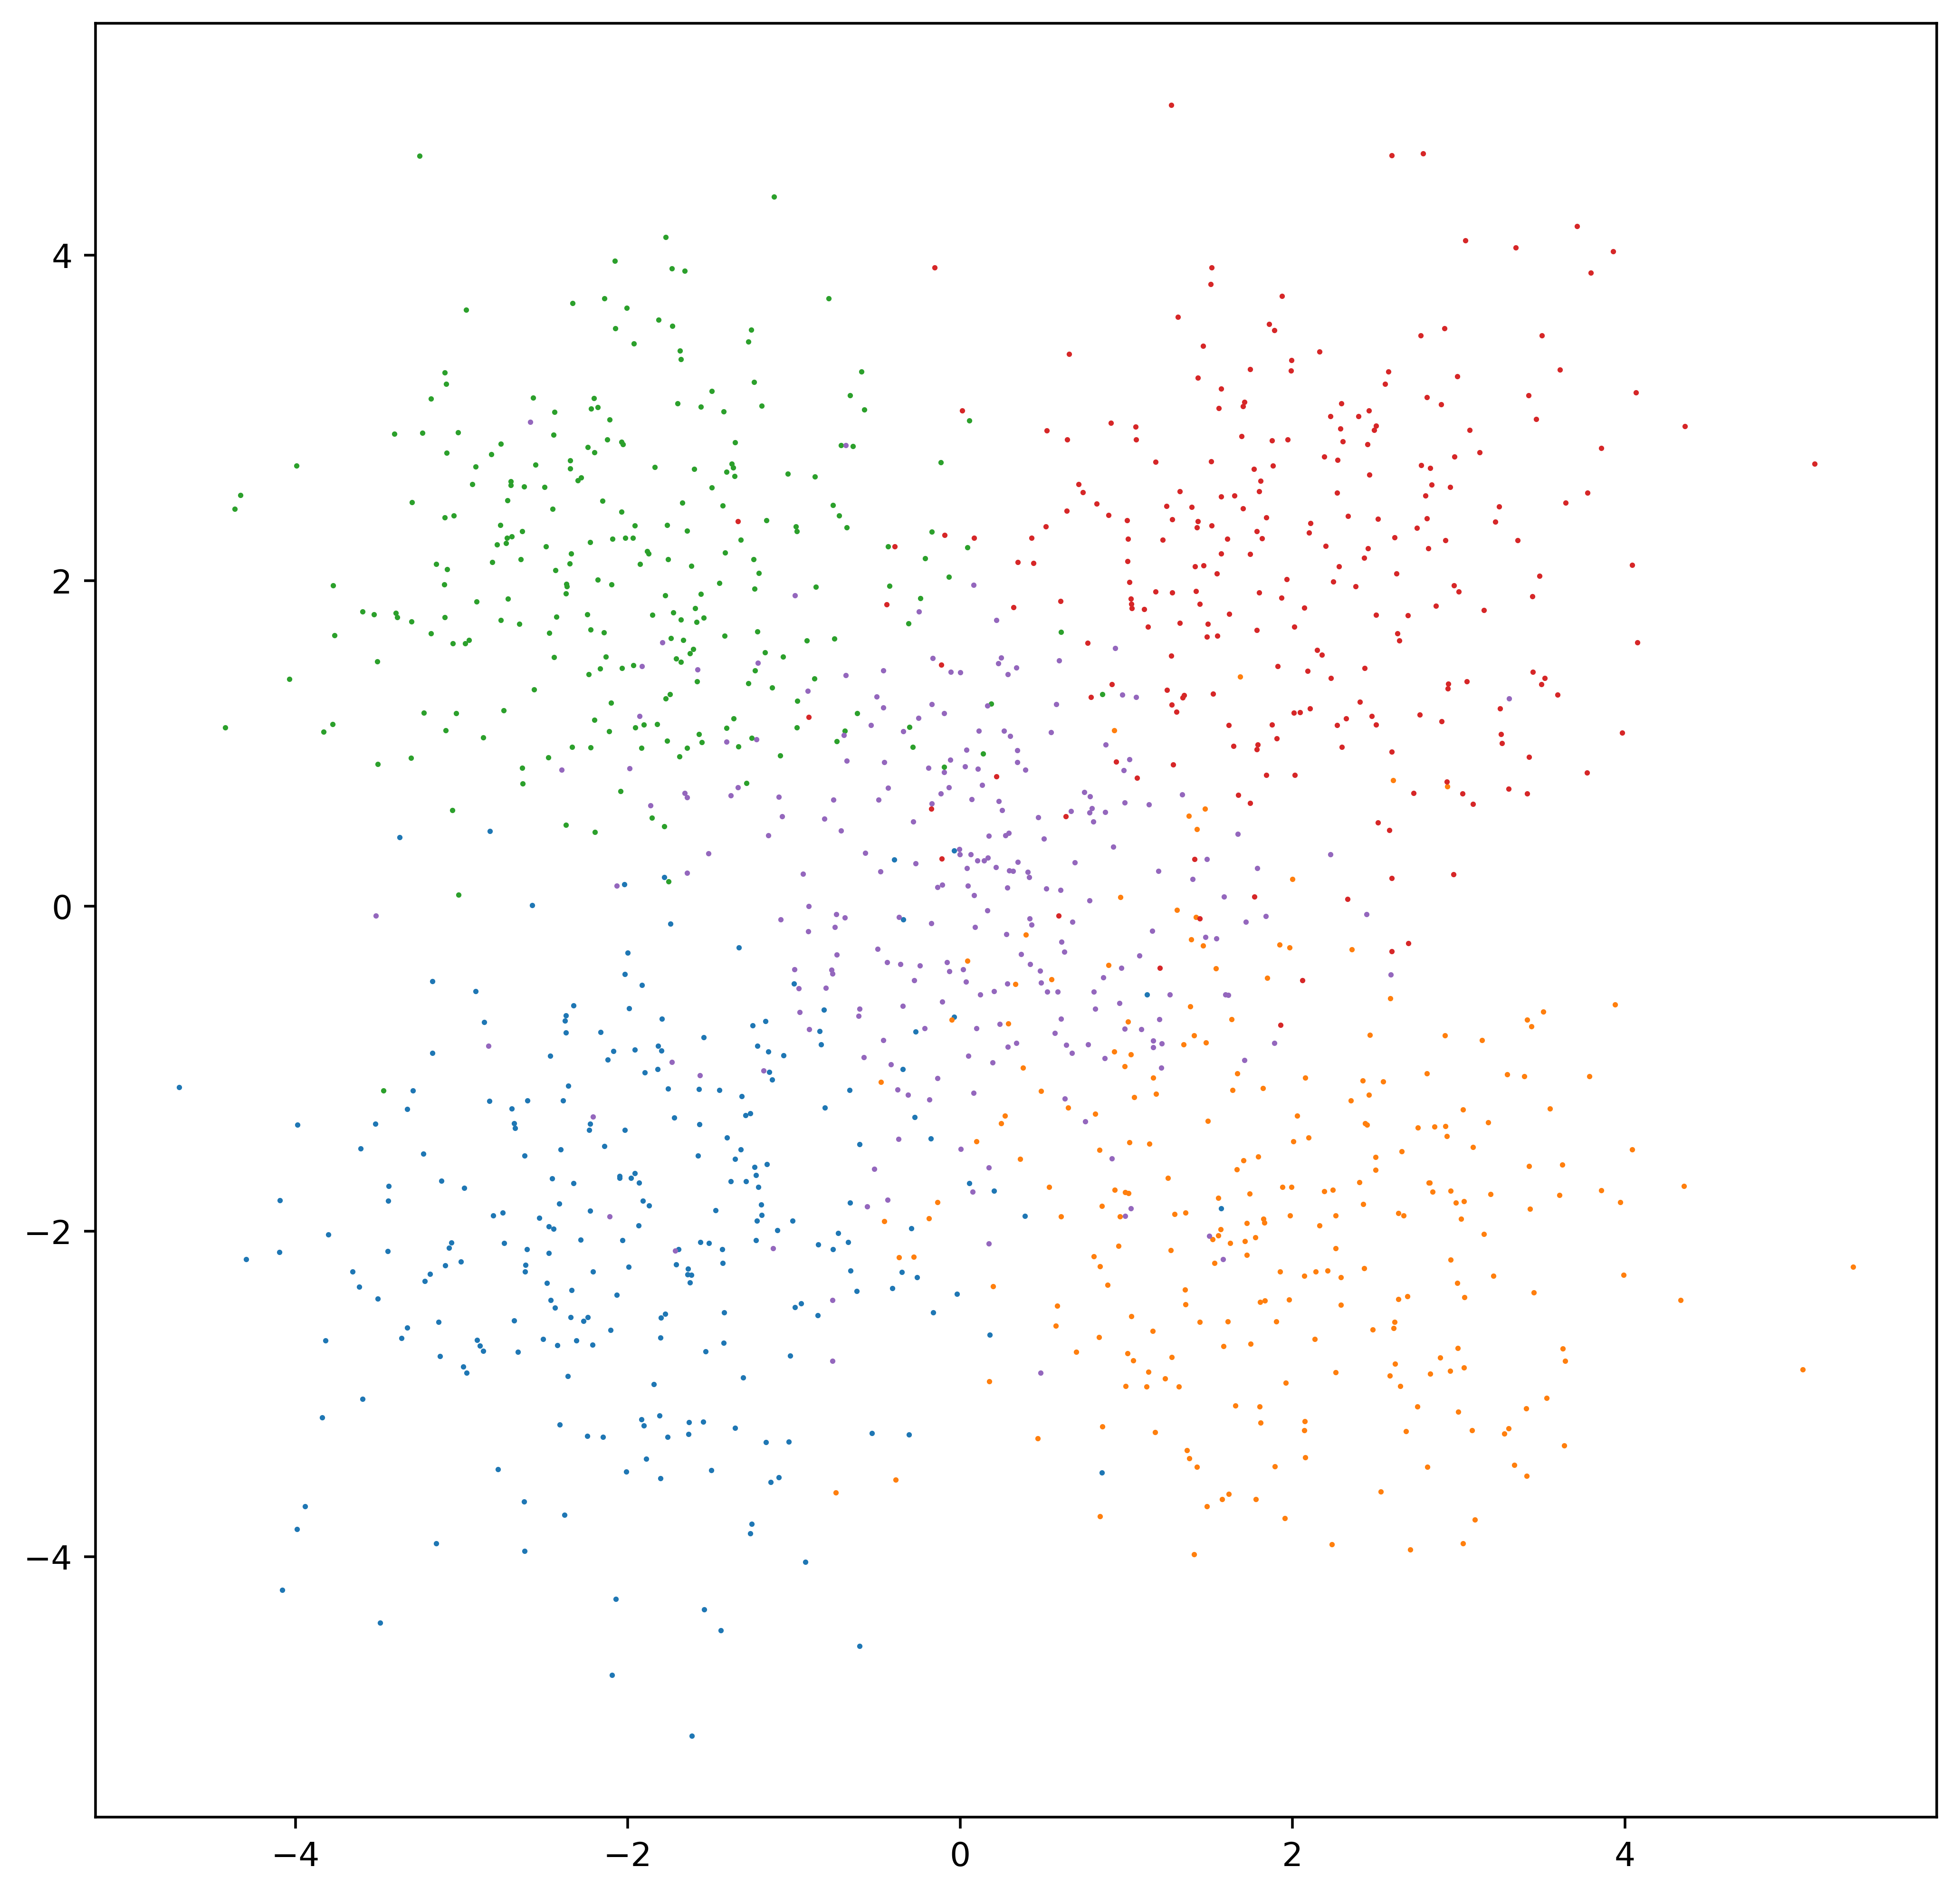

GPUs are used!
FVMF RELOADED
GPUs are used!
FVMF RELOADED
0
Random Init Utilized


/opt/uio/modules/rhel8/easybuild/software/Miniconda3/lmsunde/envs/BNN2/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


1
loss: tensor(198.5192, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(159.4439, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.5144, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(1.0287, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(165.5533, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(131.4408, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.7416, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(1.7115, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(154.6759, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(123.5268, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.8082, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(1.9658, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(144.0914, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(116.6326, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.86

Component 0 Accuracy: 848.0/1000
Component 1 Accuracy: 849.0/1000
Component 2 Accuracy: 839.0/1000
Component 3 Accuracy: 843.0/1000
Component 4 Accuracy: 845.0/1000
Component 5 Accuracy: 856.0/1000
Component 6 Accuracy: 838.0/1000
Component 7 Accuracy: 839.0/1000
Component 8 Accuracy: 854.0/1000
Component 9 Accuracy: 843.0/1000
Posterior Mean Accuracy: 861.0/1000
Ensemble Accuracy: 862/1000
0
Random Init Utilized
1
loss: tensor(145.0210, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(133.9513, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(140.4265, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(129.1998, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(135.0922, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(123.8777, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(130.9398, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(119.1864, device='cuda:1',

10
loss: tensor(57.8745, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(42.9390, device='cuda:1', grad_fn=<NllLossBackward0>)
0
1
loss: tensor(62.5406, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(48.2264, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(61.6156, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(46.9058, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(55.8229, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(42.8347, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(60.4272, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(46.1622, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(58.8962, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(44.3255, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(57.0864, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: t

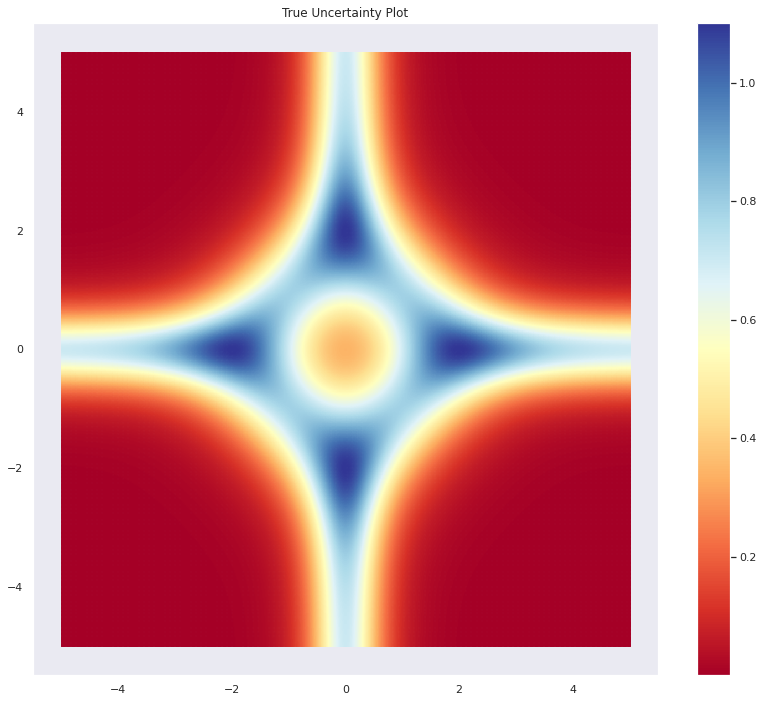

tensor(1.3012, grad_fn=<MaxBackward1>) tensor(0.0047, grad_fn=<MinBackward1>)


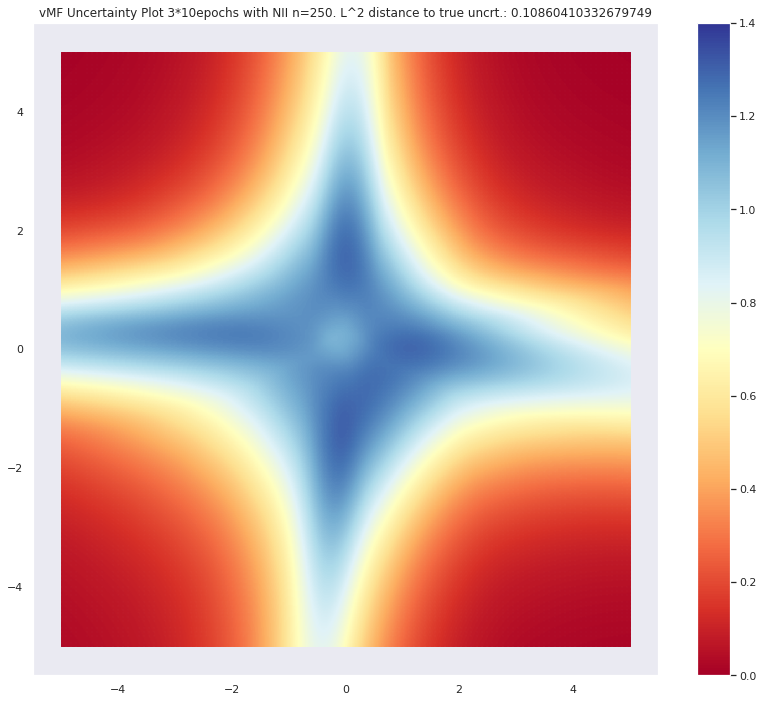

tensor(1.3692, grad_fn=<MaxBackward1>) tensor(0.0055, grad_fn=<MinBackward1>)


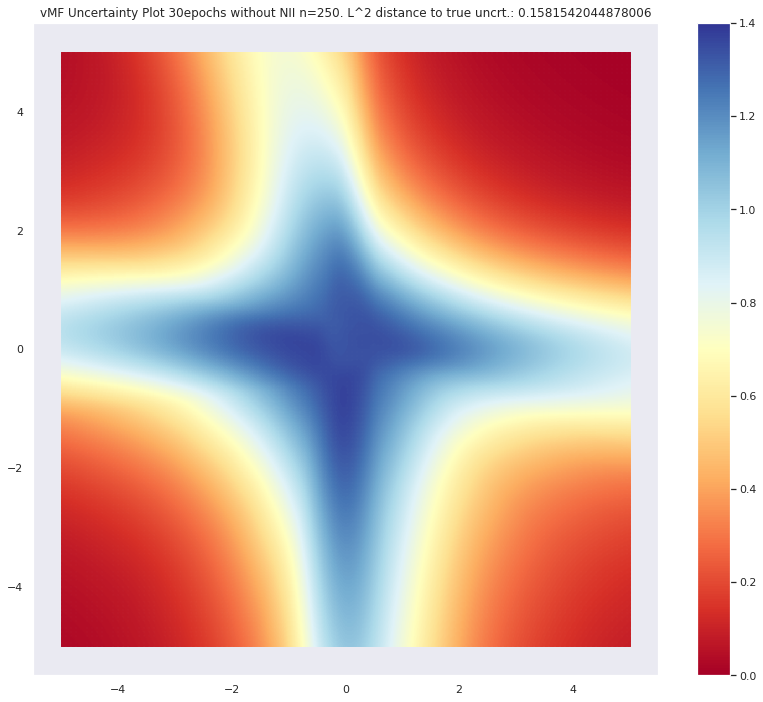

torch.Size([1056784, 5])


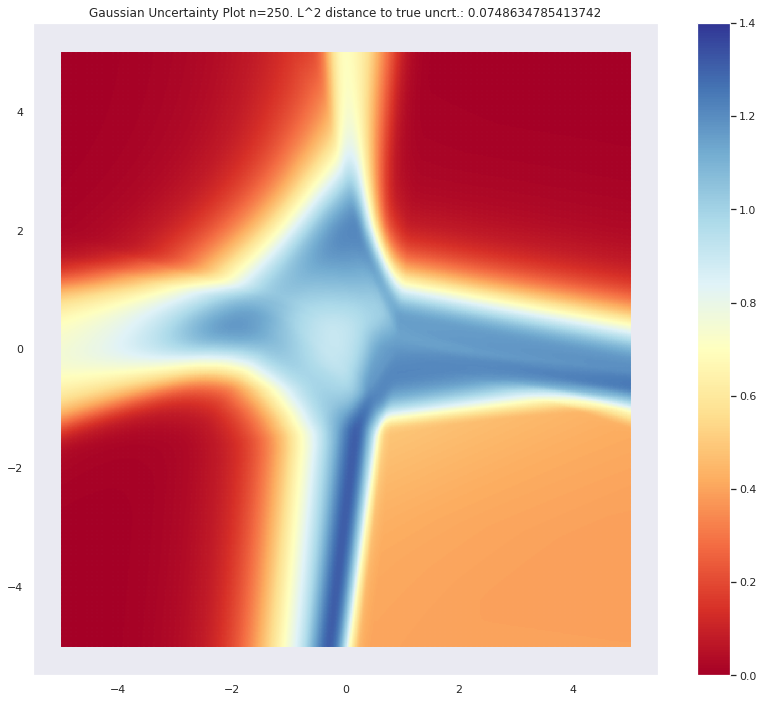

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42069)
torch.manual_seed(42069)

PL = [torch.Tensor([1-3, 1-3]),torch.Tensor([5-3, 1-3]),torch.Tensor([1-3, 5-3]),torch.Tensor([5-3, 5-3]),torch.Tensor([3-3, 3-3])]
cov = torch.eye(2)
n = 250

plt.figure(figsize=(10, 10), dpi=500)
distrib = []

DF = torch.zeros((len(PL),n,1,3)) #multiple of 4
for i, MU in enumerate(PL): #enumerate starts from and including 0.
    distrib.append(torch.distributions.multivariate_normal.MultivariateNormal(loc=MU, covariance_matrix=cov))
    DATA_ = distrib[i].sample((n,1))

    DATA  = torch.zeros([n, 1, 3])
    DATA[:,:,:2] = DATA_
    DATA[:,:,2]  = i
    DF[i,:,:,:] = DATA
    
    x = DATA[:,0,0]
    y = DATA[:,0,1]
    plt.plot(x,y,'.',markersize=1.25)
plt.show()

C = int(3*n/4)

#DATA_train = torch.zeros((len(PL)*C,3))
#DATA_test = torch.zeros((len(PL)*(n-C),3))

DATA = DF.reshape(len(PL)*n,3)
#print('DATA:',DATA,'len(DATA):',len(DATA),'mean dtrain:',DATA.mean(axis=0)[2])

#data_mean = DATA.mean(axis=1)[0:2]
#data_std = DATA.std(axis=1)[0:2]

#DATA[:,0:2] = (DATA[:,0:2]  - data_mean)/data_std
#print('DATA normalized:',DATA,'len(DATA) normalized:',len(DATA),'mean dtrain normalized:',DATA.mean(axis=0)[2])
tr_ids = np.random.choice(n*5, n*4, replace = False)



dtrain = DATA[tr_ids,:]
dtest = DATA[-tr_ids,:]


#print('\n','dtrain:',dtrain, 'len(dtrain):',len(dtrain),'mean dtrain:',dtrain.mean(axis=0)[2])
#print('\n','dtest:',dtest, 'len(dtest):',len(dtest),'mean dtest:',dtest.mean(axis=0)[2])

import math
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
import pandas as pd
import time
import mpmath
import os
import importlib


import test_ensemble
importlib.reload(test_ensemble)
import FVMF
importlib.reload(FVMF)

# define the summary writer
writer = SummaryWriter()
# select the device
DEVICE = torch.device("cuda:1")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
cuda = torch.cuda.set_device(1)

# define the parameters

COND_OPT = False
CLASSES = 5
# TRAIN_EPOCHS = 250
SAMPLES = 1
TEST_SAMPLES = 10
TEMPER = 0.001
TEMPER_PRIOR = 0.001
pepochs = 50
TEST_BATCH_SIZE = 100
BATCH_SIZE = 100

l1shape=(2, 5)
l2shape=(5, 5)
l3shape=(5, 5)
l4shape=(5, 5)
l5shape=(5, 5)
l6shape=(5, 5)
layershapes = [l1shape, l2shape, l3shape, l4shape]

# set prior parameters
PI = 1
SIGMA_1 = torch.cuda.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.cuda.FloatTensor([math.exp(-6)])
data_shape = (0,2,2,3)

epochs = 30
trtimes = []
#w_mu = [w_mu1, w_mu2, w_mu3, w_mu4]
#b_mu = [b_mu1, b_mu2, b_mu3, b_mu4]

#w_mu_nodewise = [w_mu1_nodewise,w_mu2_nodewise,w_mu3_nodewise,w_mu4_nodewise]
#b_mu_nodewise = [b_mu1_nodewise,b_mu2_nodewise,b_mu3_nodewise,b_mu4_nodewise]
# make inference on 10 networks

for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net3 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='Gaussian',
                                #b_kappa=torch.Tensor(1).uniform_(4,4.1),
                                #w_kappa=torch.Tensor(1).uniform_(6,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net3.parameters(), lr=0.04)
    
    
    for epoch in range(epochs):
        
        train = FVMF.train(net3, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        
        print('max:',net3.weight_mu[1].max())
        print('norm:',torch.norm(net3.weight_mu[1]))

    res = test_ensemble.test_ensemble(net3,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

epochs = 30
trtimes = []
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    netSimNoIIN = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4.0,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.0,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(netSimNoIIN.parameters(), lr=0.07)
    
    
    for epoch in range(epochs):

        train = FVMF.train(netSimNoIIN, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    res = test_ensemble.test_ensemble(netSimNoIIN,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

epochs = 10
trtimes = []
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4.0,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.0,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4.parameters(), lr=0.14)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net4,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

GC_intensity = 1

#Kanskje er det en god idee å også arve kappaene, men doble? Hva om vi også kjører på med litt normalizering av mu-ene her?
#Hva med adaptiv kappa per lag? Det er jo bare en kappa per bias-lag.

w_mu = []
for i in range(len(net4.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu.append(net4.weight_mu[i]/torch.norm(net4.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu = []
for i in range(len(net4.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu.append(net4.bias_mu[i]/torch.norm(net4.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho= []
for i in range(len(net4.bias_rho)):
    b_rho.append(net4.bias_rho[i]*GC_intensity)

w_rho= []
for i in range(len(net4.weight_rho)):
    w_rho.append(net4.weight_rho[i]*GC_intensity)

#print('b_rho:',b_rho, '\n','w_rho:',b_mu)

epochs = 10
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4_GC = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4_GC.parameters(), lr=0.07)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4_GC, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())#print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net4_GC,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
#print('This is the loss with the Gradient Capture method/Normalized Initialization Inheritance')

#Ok, så kanskje drit i gradient-capture-method. Men! Husk hva du har vist her nå med kun normalisering av vektene, Du får trent nettet
#Videre, og det fungerer faktisk. I tilfellet hvor du ikke gjør det ender du faktisk ikke bare opp med dårlig ytelse, men
#hele nettet brekker!!!!!!!!!!!

GC_intensity = 1

#Kanskje er det en god idee å også arve kappaene, men halvere dem? Hva om vi også kjører på med litt normalizering av mu-ene her?
#Hva med adaptiv kappa per lag? Det er jo bare en kappa per bias-lag. GC fungerer rett og slett ikke.

w_mu = []
for i in range(len(net4_GC.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu.append(net4_GC.weight_mu[i]/torch.norm(net4_GC.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu = []
for i in range(len(net4_GC.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu.append(net4_GC.bias_mu[i]/torch.norm(net4_GC.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho= []
for i in range(len(net4_GC.bias_rho)):
    b_rho.append(net4_GC.bias_rho[i]*GC_intensity)

w_rho= []
for i in range(len(net4_GC.weight_rho)):
    w_rho.append(net4_GC.weight_rho[i]*GC_intensity)

#print('b_rho:',b_rho, '\n','w_rho:',b_mu)

epochs = 10
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4_GC2 = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4_GC2.parameters(), lr=0.035)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4_GC2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())#print('max:',net4.weight_mu[1].max())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    res = test_ensemble.test_ensemble(net4_GC2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
print('This is the loss with the Gradient Capture method/Normalized Initialization Inheritance, applied twice')

RES = 1028
DEVICE = torch.device("cuda:1")
Temps4 = torch.zeros((RES**2,3))

x = torch.linspace(-5,5,RES)
Temps4[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((RES**2, 5)).to(DEVICE)


sfm = torch.nn.Softmax(dim = -1)

VAL = torch.zeros((RES**2,5)).to(DEVICE)
for i in range(len(distrib)):
    VAL[:,i] = distrib[i].log_prob(Temps4[:,0:2])

VAL2 = torch.zeros((RES**2,5)).to(DEVICE)
VAL2 = sfm(VAL)

Temps4[:,2] = -torch.sum(torch.log(VAL2) * VAL2,dim = 1) #We don't log the probs here, since they were already logged.

plt.title('True Uncertainty Plot')
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot4 = plt.scatter(Temps4[:,0].detach().numpy(), Temps4[:,1].detach().numpy(), s=221000/(RES**2), c=Temps4[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot4)
plt.savefig('Plots/True_Uncertainty_Plot.png')
plt.show()


RES = 1028 #Ca. Full HD resolution. If you struggle with memory adjust this parameter down. 64 for example already gives a decent view.
enums = 10

DEVICE = torch.device("cuda:1")
Temps = torch.zeros((RES**2,3))
i, j = 0, 0

x = torch.linspace(-5,5,RES)

Temps[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(net4_GC2(Temps[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(torch.max(Temps[:,2]),torch.min(Temps[:,2]))

L2_NIIvMF = torch.sum((Temps-Temps4)**2,dim = 1)
L2_NIIvMF = L2_NIIvMF.sum()/(1028**2)

plt.title(f"vMF Uncertainty Plot 3*10epochs with NII n=250. L^2 distance to true uncrt.: {L2_NIIvMF}")
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot = plt.scatter(Temps[:,0].detach().numpy(), Temps[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot)
plt.savefig('Plots/vMFNII_Uncertainty_Plotn250.png')
plt.show()




Temps[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(netSimNoIIN(Temps[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(torch.max(Temps[:,2]),torch.min(Temps[:,2]))

L2_vMF = torch.sum((Temps-Temps4)**2,dim = 1)
L2_vMF = L2_vMF.sum()/(1028**2)

plt.title(f"vMF Uncertainty Plot 30epochs without NII n=250. L^2 distance to true uncrt.: {L2_vMF}")
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot = plt.scatter(Temps[:,0].detach().numpy(), Temps[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot)
plt.savefig('Plots/vMF_non_NII_Uncertainty_Plotn250.png')
plt.show()



RES = 1028
enums = 10

DEVICE = torch.device("cuda:1")
Temps2 = torch.zeros((RES**2,3))
i, j = 0, 0

x = torch.linspace(-5,5,RES)

Temps2[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(net3(Temps2[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps2[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(probs.shape)

L2_Gaus = torch.sum((Temps2-Temps4)**2,dim = 1)
L2_Gaus = L2_Gaus.sum()/(1028**2)

plt.title(f"Gaussian Uncertainty Plot n=250. L^2 distance to true uncrt.: {L2_Gaus}")
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot2 = plt.scatter(Temps2[:,0].detach().numpy(), Temps2[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps2[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot2)
plt.savefig('Plots/Gaussian_Uncertainty_Plotn250.png')
plt.show()

In [2]:
print(L2_vMF.sum()/(1028**2))

tensor(1.4966e-07, grad_fn=<DivBackward0>)


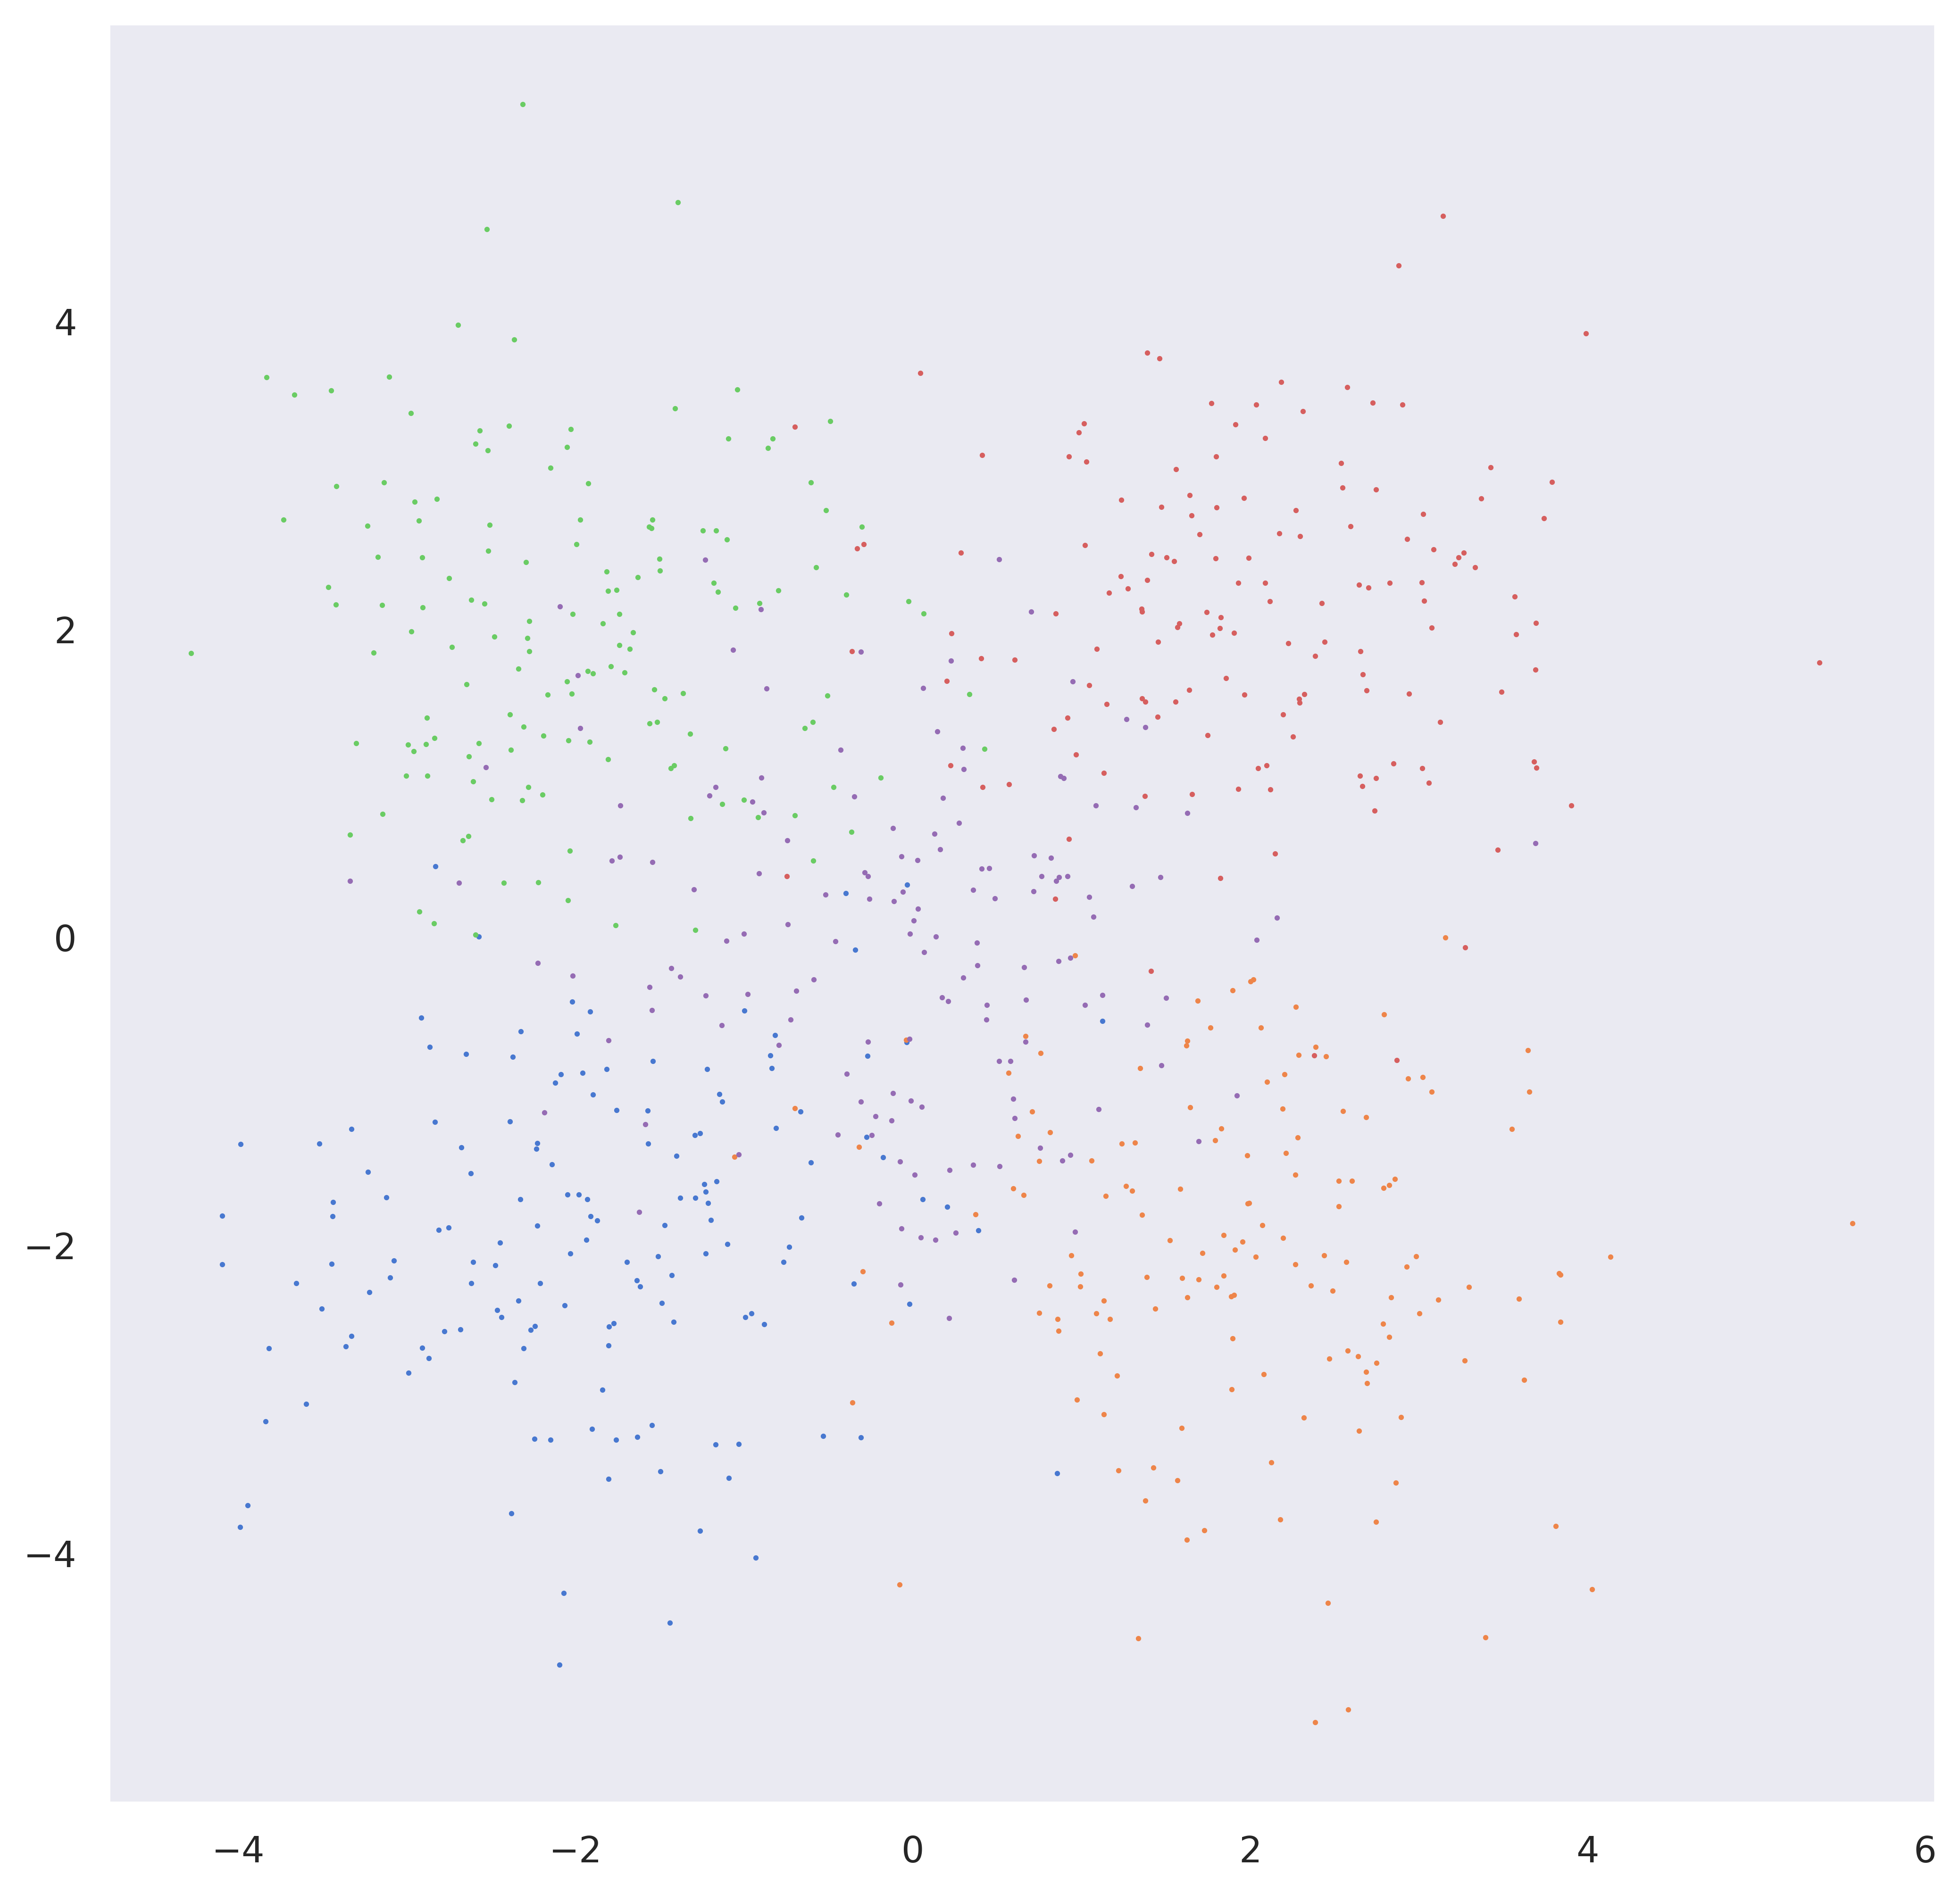

GPUs are used!
FVMF RELOADED
0
Random Init Utilized
1
loss: tensor(223.2921, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(158.0703, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.3951, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(0.7006, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(202.0611, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(138.5149, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.6271, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(1.3457, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(190.6782, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(132.7158, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.6759, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(1.5346, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(182.9703, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(129.3638, device='c

Component 0 Accuracy: 489.0/600
Component 1 Accuracy: 483.0/600
Component 2 Accuracy: 483.0/600
Component 3 Accuracy: 470.0/600
Component 4 Accuracy: 479.0/600
Component 5 Accuracy: 483.0/600
Component 6 Accuracy: 473.0/600
Component 7 Accuracy: 482.0/600
Component 8 Accuracy: 476.0/600
Component 9 Accuracy: 483.0/600
Posterior Mean Accuracy: 490.0/600
Ensemble Accuracy: 484/600
0
Random Init Utilized
1
loss: tensor(168.7845, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(149.5400, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(163.9088, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(146.9119, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(168.5573, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(148.8850, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(163.0511, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(142.5223, device='cuda:1', grad_fn=<Nl

10
loss: tensor(67.2686, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(46.8288, device='cuda:1', grad_fn=<NllLossBackward0>)
0
1
loss: tensor(75.5837, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(53.3993, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(75.7573, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(55.8457, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(74.7530, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(52.8123, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(76.5530, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(55.7960, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(67.4372, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(47.3640, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(71.8238, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: t

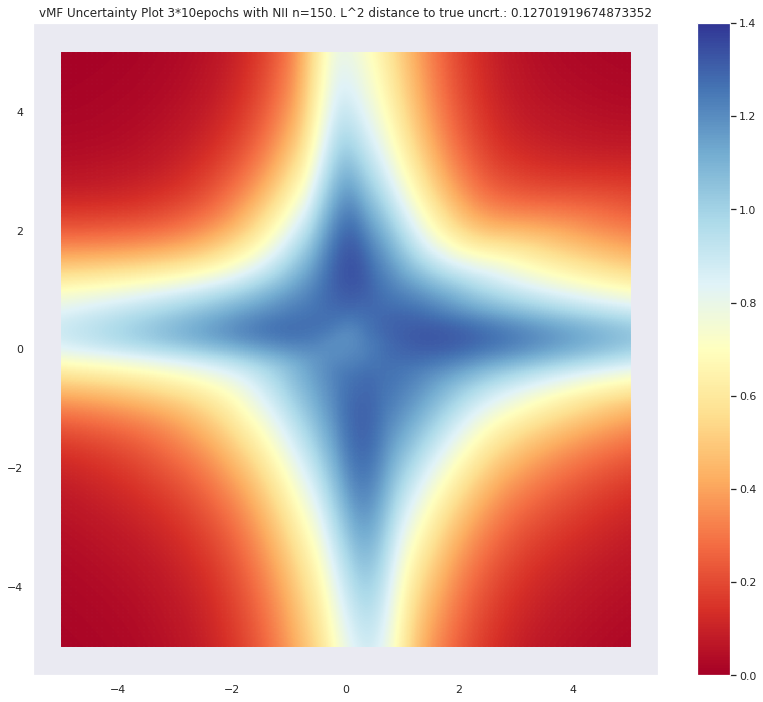

tensor(1.3712, grad_fn=<MaxBackward1>) tensor(0.0165, grad_fn=<MinBackward1>)


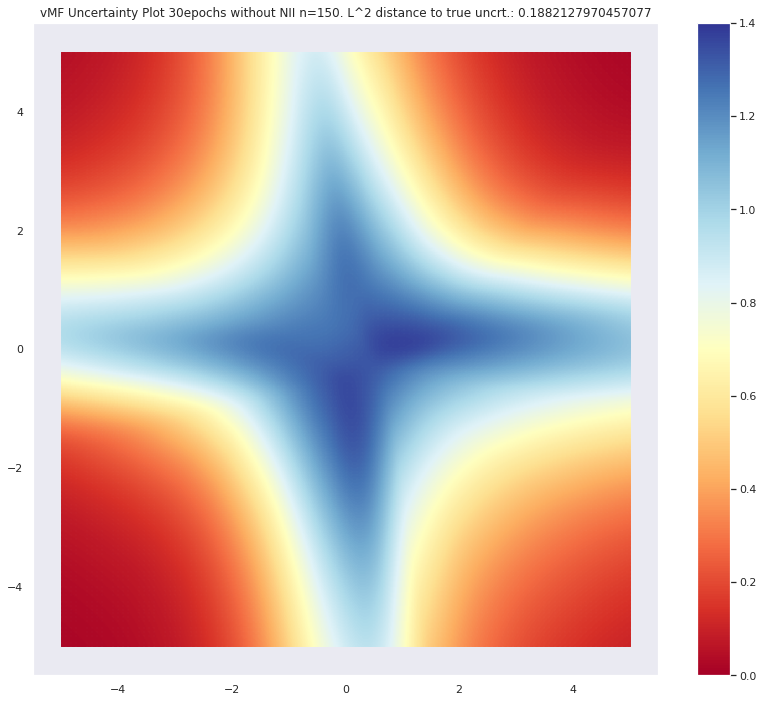

torch.Size([1056784, 5])


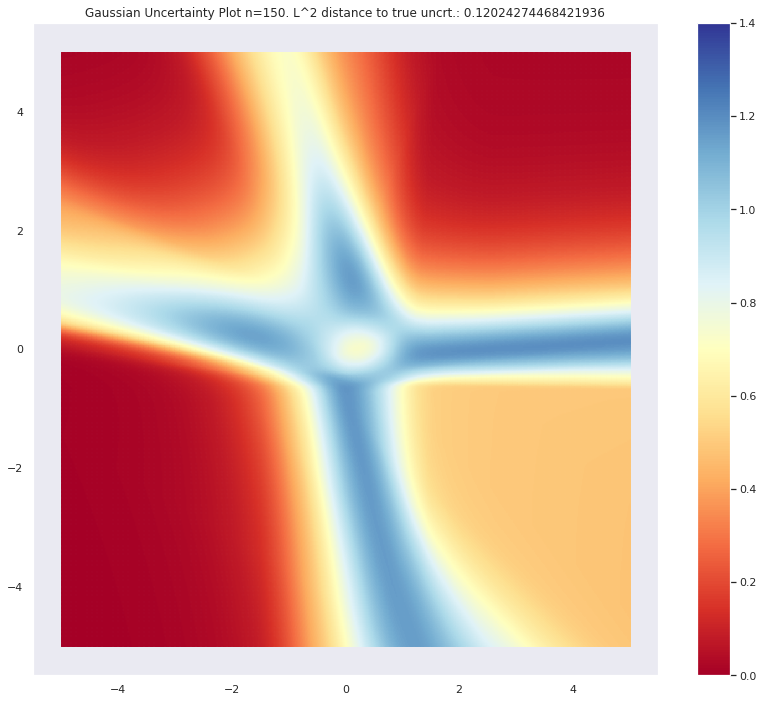

In [3]:
#Simuler marginalfordeling for en vekt fra vMF. OG sammenlign med en marginal vekt fra multivariat Gaussisk som har blitt normalisert.
#og hva skjer i posterioren etter det er trent. trekk vekter fra HU, gjør forwardpass predictions som simulert data, tren på det og sjekk om vektene blir som i starten.
#Hva med å initialisere fra HU!!!???


import torch
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42069)
torch.manual_seed(42069)

PL = [torch.Tensor([1-3, 1-3]),torch.Tensor([5-3, 1-3]),torch.Tensor([1-3, 5-3]),torch.Tensor([5-3, 5-3]),torch.Tensor([3-3, 3-3])]
cov = torch.eye(2)
n = 150

plt.figure(figsize=(10, 10), dpi=500)
distrib = []

DF = torch.zeros((len(PL),n,1,3)) #multiple of 4
for i, MU in enumerate(PL): #enumerate starts from and including 0.
    distrib.append(torch.distributions.multivariate_normal.MultivariateNormal(loc=MU, covariance_matrix=cov))
    DATA_ = distrib[i].sample((n,1))

    DATA  = torch.zeros([n, 1, 3])
    DATA[:,:,:2] = DATA_
    DATA[:,:,2]  = i
    DF[i,:,:,:] = DATA
    
    x = DATA[:,0,0]
    y = DATA[:,0,1]
    plt.plot(x,y,'.',markersize=1.25)
plt.show()

C = int(3*n/4)

#DATA_train = torch.zeros((len(PL)*C,3))
#DATA_test = torch.zeros((len(PL)*(n-C),3))

DATA = DF.reshape(len(PL)*n,3)
#print('DATA:',DATA,'len(DATA):',len(DATA),'mean dtrain:',DATA.mean(axis=0)[2])

#data_mean = DATA.mean(axis=1)[0:2]
#data_std = DATA.std(axis=1)[0:2]

#DATA[:,0:2] = (DATA[:,0:2]  - data_mean)/data_std
#print('DATA normalized:',DATA,'len(DATA) normalized:',len(DATA),'mean dtrain normalized:',DATA.mean(axis=0)[2])
tr_ids = np.random.choice(n*5, n*4, replace = False)



dtrain = DATA[tr_ids,:]
dtest = DATA[-tr_ids,:]


#print('\n','dtrain:',dtrain, 'len(dtrain):',len(dtrain),'mean dtrain:',dtrain.mean(axis=0)[2])
#print('\n','dtest:',dtest, 'len(dtest):',len(dtest),'mean dtest:',dtest.mean(axis=0)[2])

import math
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
import pandas as pd
import time
import mpmath
import os
import importlib


import test_ensemble
importlib.reload(test_ensemble)
import FVMF
importlib.reload(FVMF)

# define the summary writer
writer = SummaryWriter()
# select the device
DEVICE = torch.device("cuda:1")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
cuda = torch.cuda.set_device(1)

# define the parameters

COND_OPT = False
CLASSES = 5
# TRAIN_EPOCHS = 250
SAMPLES = 1
TEST_SAMPLES = 10
TEMPER = 0.001
TEMPER_PRIOR = 0.001
pepochs = 50
TEST_BATCH_SIZE = 100
BATCH_SIZE = 100

l1shape=(2, 5)
l2shape=(5, 5)
l3shape=(5, 5)
l4shape=(5, 5)
l5shape=(5, 5)
l6shape=(5, 5)
layershapes = [l1shape, l2shape, l3shape, l4shape]

# set prior parameters
PI = 1
SIGMA_1 = torch.cuda.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.cuda.FloatTensor([math.exp(-6)])
data_shape = (0,2,2,3)

epochs = 30
trtimes = []
#w_mu = [w_mu1, w_mu2, w_mu3, w_mu4]
#b_mu = [b_mu1, b_mu2, b_mu3, b_mu4]

#w_mu_nodewise = [w_mu1_nodewise,w_mu2_nodewise,w_mu3_nodewise,w_mu4_nodewise]
#b_mu_nodewise = [b_mu1_nodewise,b_mu2_nodewise,b_mu3_nodewise,b_mu4_nodewise]
# make inference on 10 networks

for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net3 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='Gaussian',
                                #b_kappa=torch.Tensor(1).uniform_(4,4.1),
                                #w_kappa=torch.Tensor(1).uniform_(6,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net3.parameters(), lr=0.04)
    
    
    for epoch in range(epochs):
        
        train = FVMF.train(net3, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        
        print('max:',net3.weight_mu[1].max())
        print('norm:',torch.norm(net3.weight_mu[1]))
    print('\n','Testacc Gaussian 150:')
    res = test_ensemble.test_ensemble(net3,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

epochs = 30
trtimes = []
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    netSimNoIIN = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4.0,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.0,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(netSimNoIIN.parameters(), lr=0.07)
    
    
    for epoch in range(epochs):

        train = FVMF.train(netSimNoIIN, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))
    print('\n','Testacc for non-NII vMF 150:')
    res = test_ensemble.test_ensemble(netSimNoIIN,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

epochs = 10
trtimes = []
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4.0,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.0,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4.parameters(), lr=0.14)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net4,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

GC_intensity = 1

w_mu = []
for i in range(len(net4.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu.append(net4.weight_mu[i]/torch.norm(net4.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu = []
for i in range(len(net4.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu.append(net4.bias_mu[i]/torch.norm(net4.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho= []
for i in range(len(net4.bias_rho)):
    b_rho.append(net4.bias_rho[i]*GC_intensity)

w_rho= []
for i in range(len(net4.weight_rho)):
    w_rho.append(net4.weight_rho[i]*GC_intensity)

#print('b_rho:',b_rho, '\n','w_rho:',b_mu)

epochs = 10
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4_GC = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4_GC.parameters(), lr=0.05)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4_GC, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())#print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net4_GC,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)



GC_intensity = 1

#Kanskje er det en god idee å også arve kappaene, men halvere dem? Hva om vi også kjører på med litt normalizering av mu-ene her?
#Hva med adaptiv kappa per lag? Det er jo bare en kappa per bias-lag. GC fungerer rett og slett ikke.

w_mu = []
for i in range(len(net4_GC.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu.append(net4_GC.weight_mu[i]/torch.norm(net4_GC.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu = []
for i in range(len(net4_GC.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu.append(net4_GC.bias_mu[i]/torch.norm(net4_GC.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho= []
for i in range(len(net4_GC.bias_rho)):
    b_rho.append(net4_GC.bias_rho[i]*GC_intensity)

w_rho= []
for i in range(len(net4_GC.weight_rho)):
    w_rho.append(net4_GC.weight_rho[i]*GC_intensity)

#print('b_rho:',b_rho, '\n','w_rho:',b_mu)

epochs = 10
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4_GC2 = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4_GC2.parameters(), lr=0.02)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4_GC2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())#print('max:',net4.weight_mu[1].max())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))
    print('\n','Testacc for NII vMF 150:')
    res = test_ensemble.test_ensemble(net4_GC2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
enums = 10

DEVICE = torch.device("cuda:1")
Temps = torch.zeros((RES**2,3))
i, j = 0, 0

x = torch.linspace(-5,5,RES)

Temps[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(net4_GC2(Temps[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(torch.max(Temps[:,2]),torch.min(Temps[:,2]))

L2_NIIvMF = torch.sum((Temps-Temps4)**2,dim = 1)
L2_NIIvMF = L2_NIIvMF.sum()/(1028**2)

plt.title(f"vMF Uncertainty Plot 3*10epochs with NII n=150. L^2 distance to true uncrt.: {L2_NIIvMF}")
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot = plt.scatter(Temps[:,0].detach().numpy(), Temps[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot)
plt.savefig('Plots/vMFNII_Uncertainty_Plotn150.png')
plt.show()




Temps[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(netSimNoIIN(Temps[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(torch.max(Temps[:,2]),torch.min(Temps[:,2]))

L2_vMF = torch.sum((Temps-Temps4)**2,dim = 1)
L2_vMF = L2_vMF.sum()/(1028**2)

plt.title(f"vMF Uncertainty Plot 30epochs without NII n=150. L^2 distance to true uncrt.: {L2_vMF}")
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot = plt.scatter(Temps[:,0].detach().numpy(), Temps[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot)
plt.savefig('Plots/vMF_non_NII_Uncertainty_Plotn150.png')
plt.show()




DEVICE = torch.device("cuda:1")
Temps2 = torch.zeros((RES**2,3))
i, j = 0, 0

x = torch.linspace(-5,5,RES)

Temps2[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(net3(Temps2[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps2[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(probs.shape)

L2_Gaus = torch.sum((Temps2-Temps4)**2,dim = 1)
L2_Gaus = L2_Gaus.sum()/(1028**2)

plt.title(f"Gaussian Uncertainty Plot n=150. L^2 distance to true uncrt.: {L2_Gaus}")
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot2 = plt.scatter(Temps2[:,0].detach().numpy(), Temps2[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps2[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot2)
plt.savefig('Plots/Gaussian_Uncertainty_Plotn150.png')
plt.show()

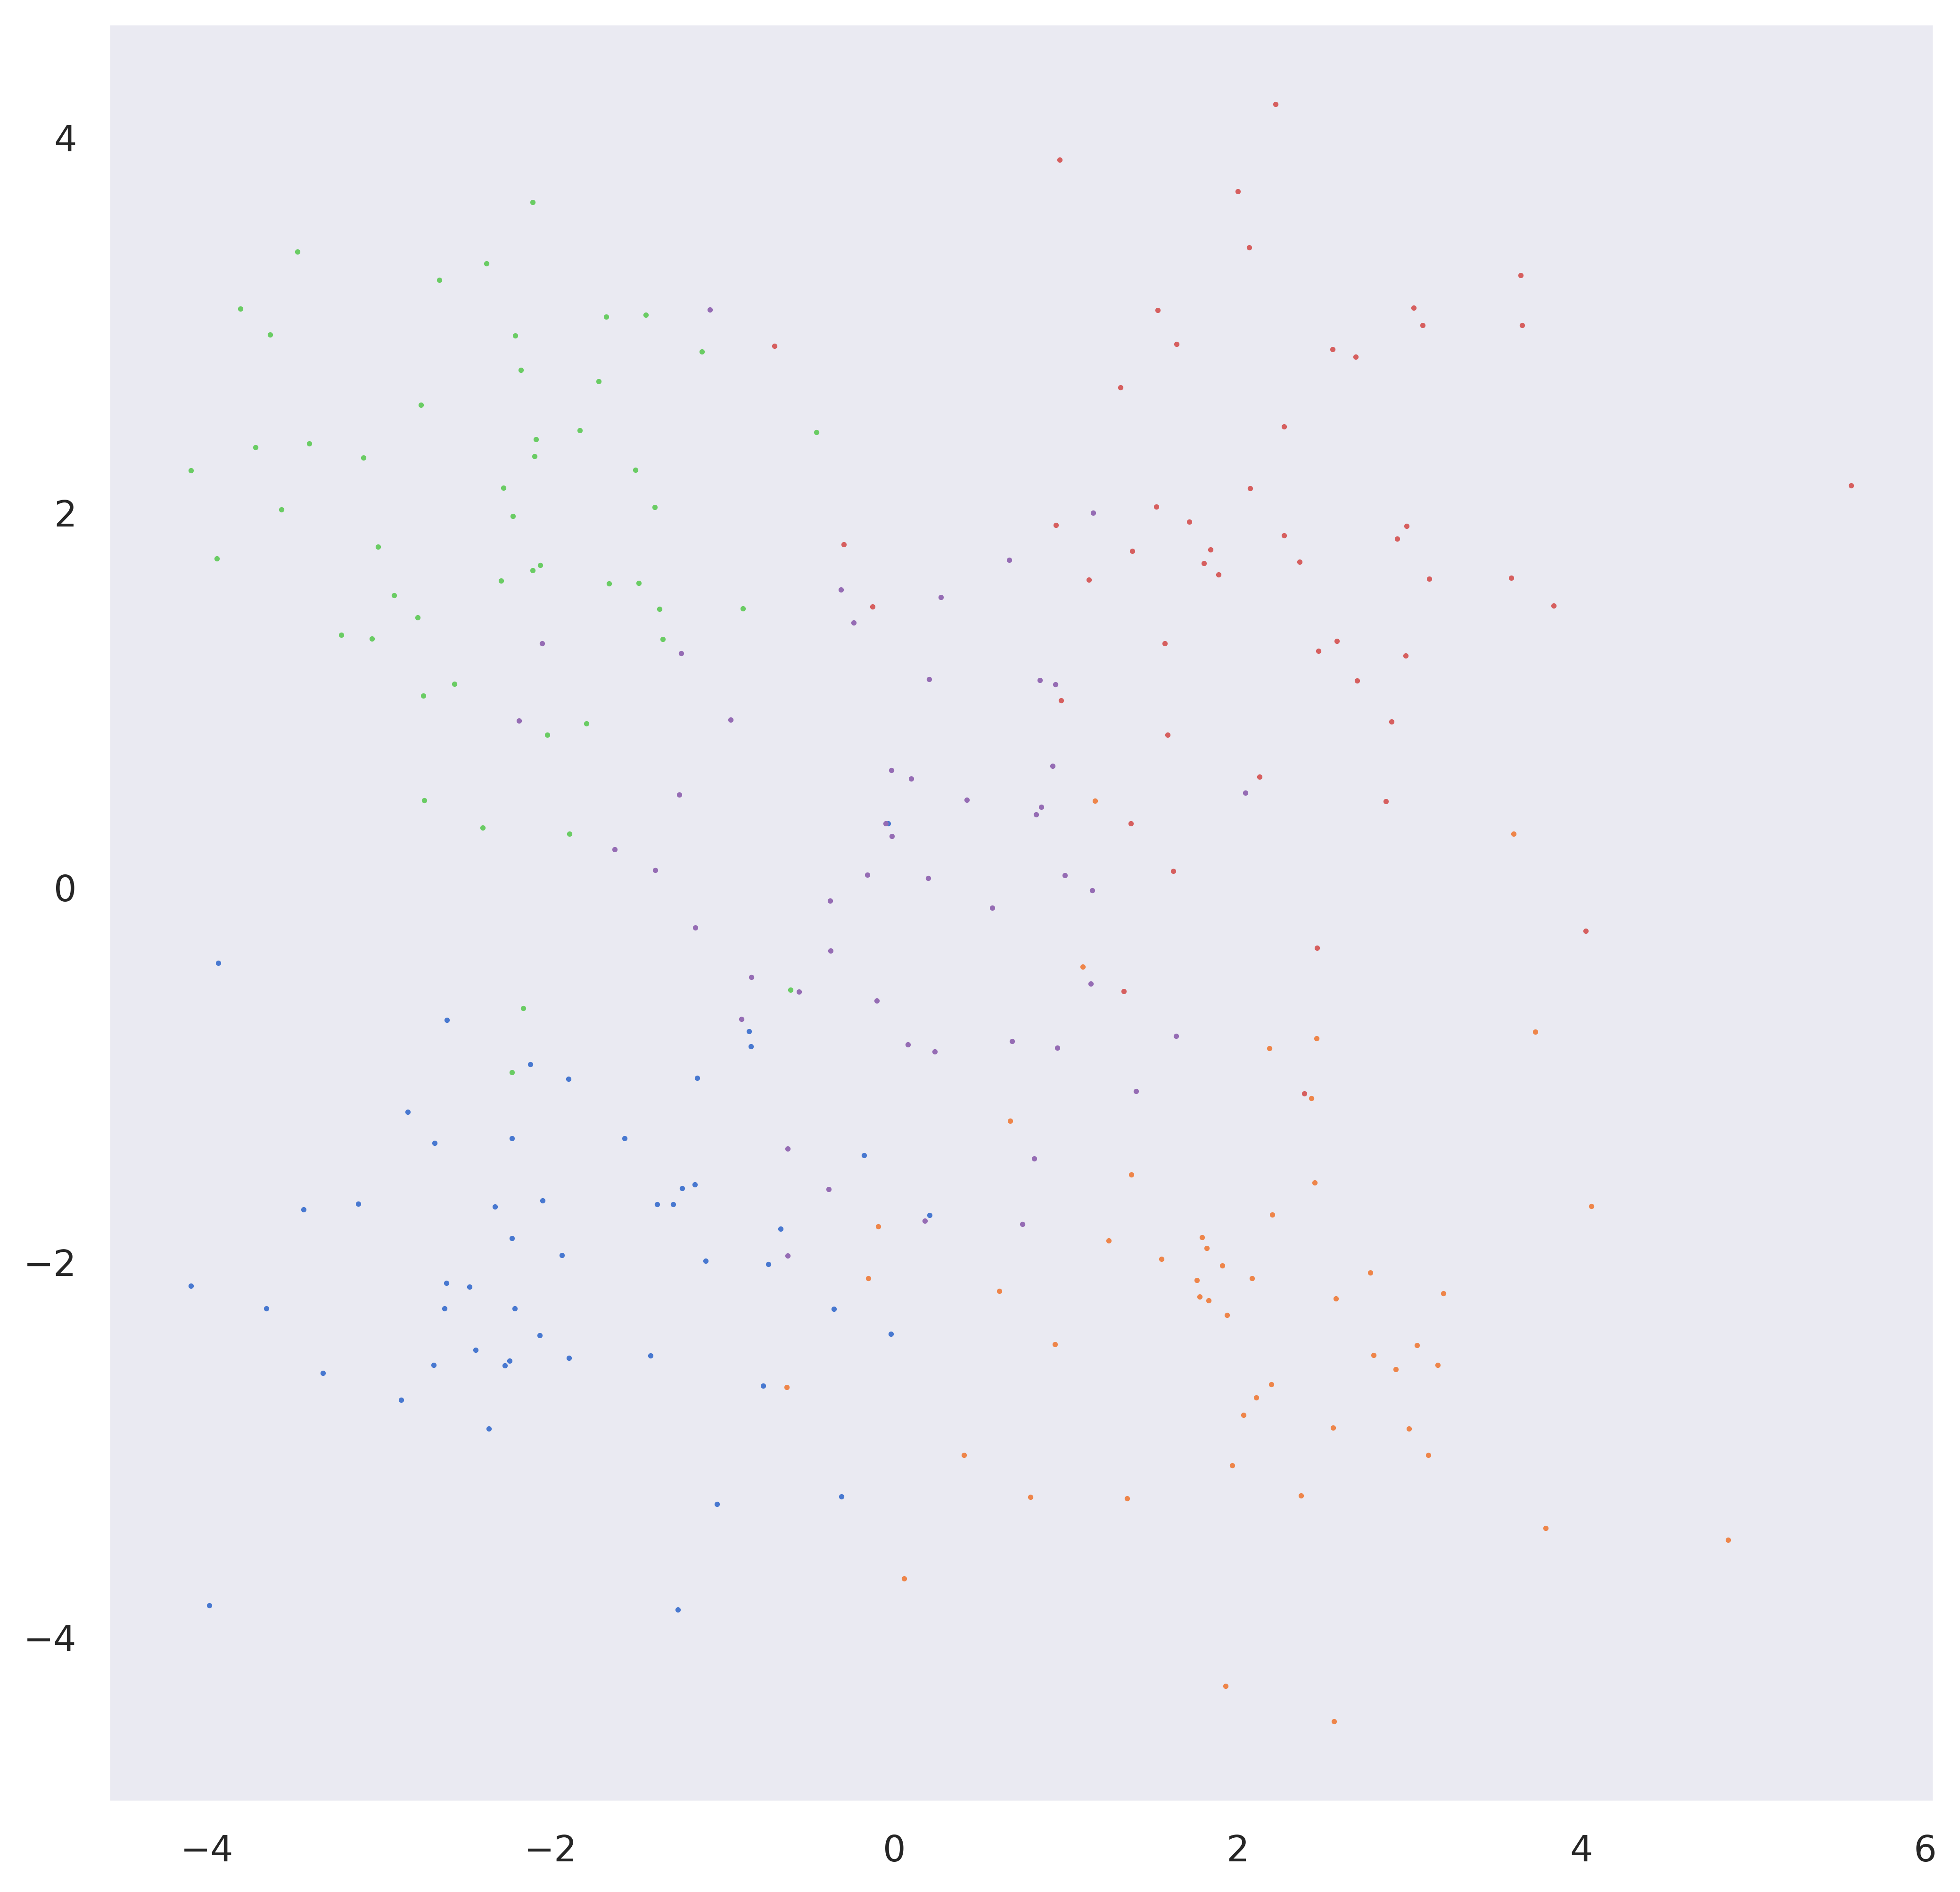

GPUs are used!
FVMF RELOADED
0
Random Init Utilized
1
loss: tensor(360.1822, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(161.0206, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.2513, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(0.4003, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(362.7167, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(160.7176, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.3170, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(0.4223, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(355.4470, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(159.9962, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.3869, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(0.5680, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(351.3536, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(157.6092, device='c

1
loss: tensor(207.0498, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(149.3496, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(200.0735, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(142.0502, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(199.9675, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(142.2340, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(196.7512, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(141.7046, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(194.9177, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(139.5752, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(187.8101, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(136.8246, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(192.4172, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_lik

2
loss: tensor(148.5425, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(90.6720, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(151.9984, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(92.7284, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(141.9708, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(84.1423, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(146.2350, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(91.0946, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(138.0520, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(85.7763, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(133.5352, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(78.0125, device='cuda:1', grad_fn=<NllLossBackward0>)
8
loss: tensor(137.9822, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihoo

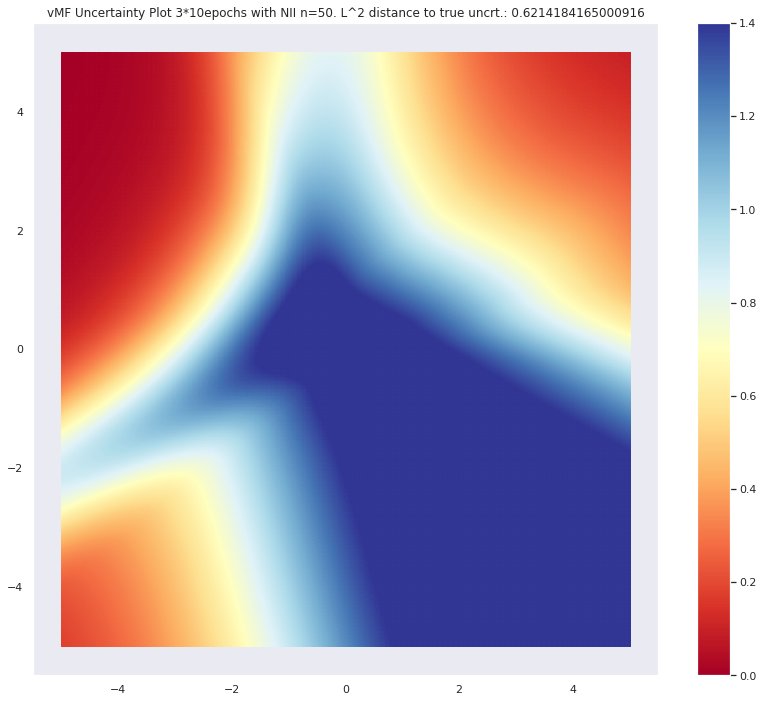

tensor(1.5997, grad_fn=<MaxBackward1>) tensor(0.0112, grad_fn=<MinBackward1>)


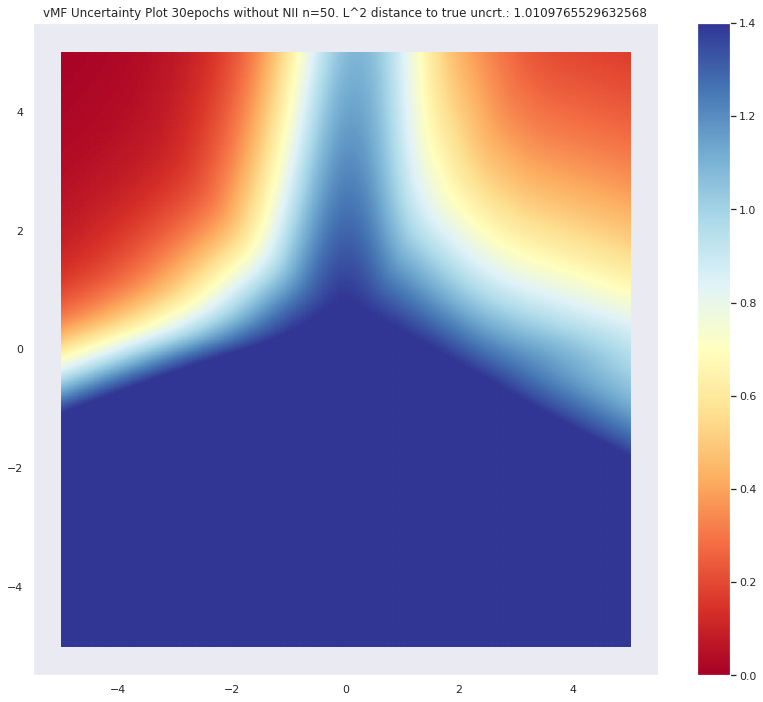

torch.Size([1056784, 5])


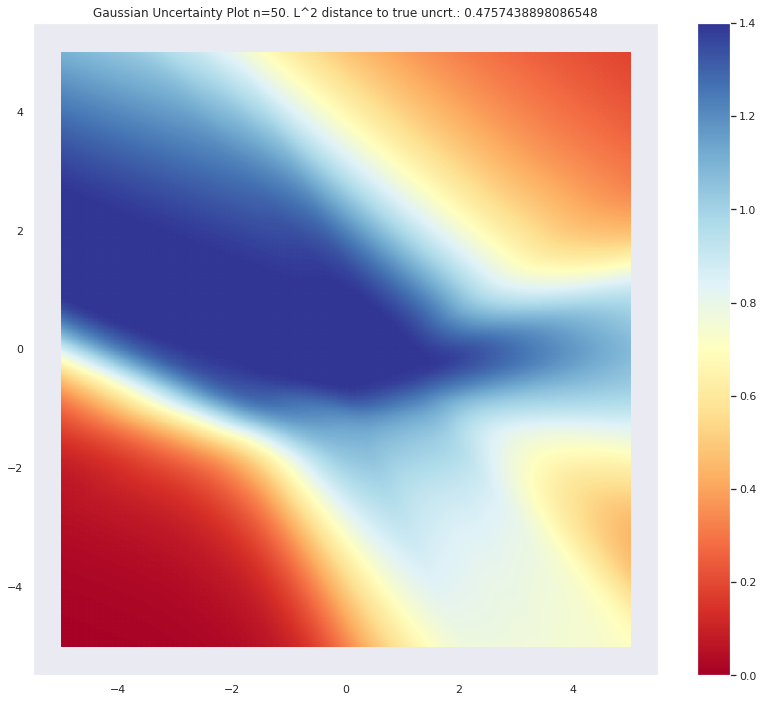

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42069)
torch.manual_seed(42069)

PL = [torch.Tensor([1-3, 1-3]),torch.Tensor([5-3, 1-3]),torch.Tensor([1-3, 5-3]),torch.Tensor([5-3, 5-3]),torch.Tensor([3-3, 3-3])]
cov = torch.eye(2)
n = 50

plt.figure(figsize=(10, 10), dpi=500)
distrib = []

DF = torch.zeros((len(PL),n,1,3)) #multiple of 4
for i, MU in enumerate(PL): #enumerate starts from and including 0.
    distrib.append(torch.distributions.multivariate_normal.MultivariateNormal(loc=MU, covariance_matrix=cov))
    DATA_ = distrib[i].sample((n,1))

    DATA  = torch.zeros([n, 1, 3])
    DATA[:,:,:2] = DATA_
    DATA[:,:,2]  = i
    DF[i,:,:,:] = DATA
    
    x = DATA[:,0,0]
    y = DATA[:,0,1]
    plt.plot(x,y,'.',markersize=1.25)
plt.show()

C = int(3*n/4)

#DATA_train = torch.zeros((len(PL)*C,3))
#DATA_test = torch.zeros((len(PL)*(n-C),3))

DATA = DF.reshape(len(PL)*n,3)
#print('DATA:',DATA,'len(DATA):',len(DATA),'mean dtrain:',DATA.mean(axis=0)[2])

#data_mean = DATA.mean(axis=1)[0:2]
#data_std = DATA.std(axis=1)[0:2]

#DATA[:,0:2] = (DATA[:,0:2]  - data_mean)/data_std
#print('DATA normalized:',DATA,'len(DATA) normalized:',len(DATA),'mean dtrain normalized:',DATA.mean(axis=0)[2])
tr_ids = np.random.choice(n*5, n*4, replace = False)



dtrain = DATA[tr_ids,:]
dtest = DATA[-tr_ids,:]


#print('\n','dtrain:',dtrain, 'len(dtrain):',len(dtrain),'mean dtrain:',dtrain.mean(axis=0)[2])
#print('\n','dtest:',dtest, 'len(dtest):',len(dtest),'mean dtest:',dtest.mean(axis=0)[2])

import math
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
import pandas as pd
import time
import mpmath
import os
import importlib


import test_ensemble
importlib.reload(test_ensemble)
import FVMF
importlib.reload(FVMF)

# define the summary writer
writer = SummaryWriter()
# select the device
DEVICE = torch.device("cuda:1")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
cuda = torch.cuda.set_device(1)

# define the parameters

COND_OPT = False
CLASSES = 5
# TRAIN_EPOCHS = 250
SAMPLES = 1
TEST_SAMPLES = 10
TEMPER = 0.001
TEMPER_PRIOR = 0.001
pepochs = 50
TEST_BATCH_SIZE = 100
BATCH_SIZE = 100

l1shape=(2, 5)
l2shape=(5, 5)
l3shape=(5, 5)
l4shape=(5, 5)
l5shape=(5, 5)
l6shape=(5, 5)
layershapes = [l1shape, l2shape, l3shape, l4shape]

# set prior parameters
PI = 1
SIGMA_1 = torch.cuda.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.cuda.FloatTensor([math.exp(-6)])
data_shape = (0,2,2,3)

epochs = 30
trtimes = []
#w_mu = [w_mu1, w_mu2, w_mu3, w_mu4]
#b_mu = [b_mu1, b_mu2, b_mu3, b_mu4]

#w_mu_nodewise = [w_mu1_nodewise,w_mu2_nodewise,w_mu3_nodewise,w_mu4_nodewise]
#b_mu_nodewise = [b_mu1_nodewise,b_mu2_nodewise,b_mu3_nodewise,b_mu4_nodewise]
# make inference on 10 networks

for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net3 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='Gaussian',
                                #b_kappa=torch.Tensor(1).uniform_(4,4.1),
                                #w_kappa=torch.Tensor(1).uniform_(6,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net3.parameters(), lr=0.04)
    
    
    for epoch in range(epochs):
        
        train = FVMF.train(net3, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        
        print('max:',net3.weight_mu[1].max())
        print('norm:',torch.norm(net3.weight_mu[1]))
    print('\n','Testacc Gaussian 50:')
    res = test_ensemble.test_ensemble(net3,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

epochs = 30
trtimes = []
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    netSimNoIIN = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4.0,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.0,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(netSimNoIIN.parameters(), lr=0.07)
    
    
    for epoch in range(epochs):

        train = FVMF.train(netSimNoIIN, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))
    print('\n','Testacc for non-NII vMF 50:')
    res = test_ensemble.test_ensemble(netSimNoIIN,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

epochs = 10
trtimes = []
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4.0,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.0,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4.parameters(), lr=0.14)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net4,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

GC_intensity = 1

#Kanskje er det en god idee å også arve kappaene, men doble? Hva om vi også kjører på med litt normalizering av mu-ene her?
#Hva med adaptiv kappa per lag? Det er jo bare en kappa per bias-lag.

w_mu = []
for i in range(len(net4.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu.append(net4.weight_mu[i]/torch.norm(net4.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu = []
for i in range(len(net4.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu.append(net4.bias_mu[i]/torch.norm(net4.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho= []
for i in range(len(net4.bias_rho)):
    b_rho.append(net4.bias_rho[i]*GC_intensity)

w_rho= []
for i in range(len(net4.weight_rho)):
    w_rho.append(net4.weight_rho[i]*GC_intensity)

#print('b_rho:',b_rho, '\n','w_rho:',b_mu)

epochs = 10
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4_GC = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4_GC.parameters(), lr=0.05)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4_GC, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())#print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net4_GC,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
#print('This is the loss with the Gradient Capture method/Normalized Initialization Inheritance')

#Ok, så kanskje drit i gradient-capture-method. Men! Husk hva du har vist her nå med kun normalisering av vektene, Du får trent nettet
#Videre, og det fungerer faktisk. I tilfellet hvor du ikke gjør det ender du faktisk ikke bare opp med dårlig ytelse, men
#hele nettet brekker!!!!!!!!!!!

GC_intensity = 1

#Kanskje er det en god idee å også arve kappaene, men halvere dem? Hva om vi også kjører på med litt normalizering av mu-ene her?
#Hva med adaptiv kappa per lag? Det er jo bare en kappa per bias-lag. GC fungerer rett og slett ikke.

w_mu = []
for i in range(len(net4_GC.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu.append(net4_GC.weight_mu[i]/torch.norm(net4_GC.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu = []
for i in range(len(net4_GC.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu.append(net4_GC.bias_mu[i]/torch.norm(net4_GC.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho= []
for i in range(len(net4_GC.bias_rho)):
    b_rho.append(net4_GC.bias_rho[i]*GC_intensity)

w_rho= []
for i in range(len(net4_GC.weight_rho)):
    w_rho.append(net4_GC.weight_rho[i]*GC_intensity)

#print('b_rho:',b_rho, '\n','w_rho:',b_mu)

epochs = 10
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4_GC2 = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4_GC2.parameters(), lr=0.02)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4_GC2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())#print('max:',net4.weight_mu[1].max())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))
    print('\n','Testacc for NII vMF 50:')
    res = test_ensemble.test_ensemble(net4_GC2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

enums = 10

DEVICE = torch.device("cuda:1")
Temps = torch.zeros((RES**2,3))
i, j = 0, 0

x = torch.linspace(-5,5,RES)

Temps[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(net4_GC2(Temps[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(torch.max(Temps[:,2]),torch.min(Temps[:,2]))

L2_NIIvMF = torch.sum((Temps-Temps4)**2,dim = 1)
L2_NIIvMF = L2_NIIvMF.sum()/(1028**2)

plt.title(f"vMF Uncertainty Plot 3*10epochs with NII n=50. L^2 distance to true uncrt.: {L2_NIIvMF}")
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot = plt.scatter(Temps[:,0].detach().numpy(), Temps[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot)
plt.savefig('Plots/vMFNII_Uncertainty_Plotn150.png')
plt.show()




Temps[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(netSimNoIIN(Temps[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(torch.max(Temps[:,2]),torch.min(Temps[:,2]))

L2_vMF = torch.sum((Temps-Temps4)**2,dim = 1)
L2_vMF = L2_vMF.sum()/(1028**2)

plt.title(f"vMF Uncertainty Plot 30epochs without NII n=50. L^2 distance to true uncrt.: {L2_vMF}")
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot = plt.scatter(Temps[:,0].detach().numpy(), Temps[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot)
plt.savefig('Plots/vMF_non_NII_Uncertainty_Plotn150.png')
plt.show()




DEVICE = torch.device("cuda:1")
Temps2 = torch.zeros((RES**2,3))
i, j = 0, 0

x = torch.linspace(-5,5,RES)

Temps2[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(net3(Temps2[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps2[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(probs.shape)

L2_Gaus = torch.sum((Temps2-Temps4)**2,dim = 1)
L2_Gaus = L2_Gaus.sum()/(1028**2)

plt.title(f"Gaussian Uncertainty Plot n=50. L^2 distance to true uncrt.: {L2_Gaus}")
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot2 = plt.scatter(Temps2[:,0].detach().numpy(), Temps2[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps2[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot2)
plt.savefig('Plots/Gaussian_Uncertainty_Plotn50.png')
plt.show()